In [1]:
%load_ext tensorboard
import os
import numpy as np
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
from datetime import datetime
from packaging import version
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models,layers
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."

TensorFlow version:  2.15.0


In [2]:
import tensorboard
tensorboard.__version__

'2.15.1'

In [3]:
rm -rf ./logs/

In [4]:
Image_Size = 256
Batch_Size = 32
channels = 3
Epochs = 85
input_shape = (Batch_Size,Image_Size,Image_Size,channels)

In [5]:
df = tf.keras.preprocessing.image_dataset_from_directory(
    "metal_nut/test/",
    shuffle = True,
    image_size = (Image_Size,Image_Size),
    batch_size = Batch_Size
)

Found 471 files belonging to 5 classes.


In [6]:
class_names = df.class_names
class_names = [class_name for class_name in class_names if class_name != '.ipynb_checkpoints']

class_names

['bent', 'color', 'flip', 'good', 'scratch']

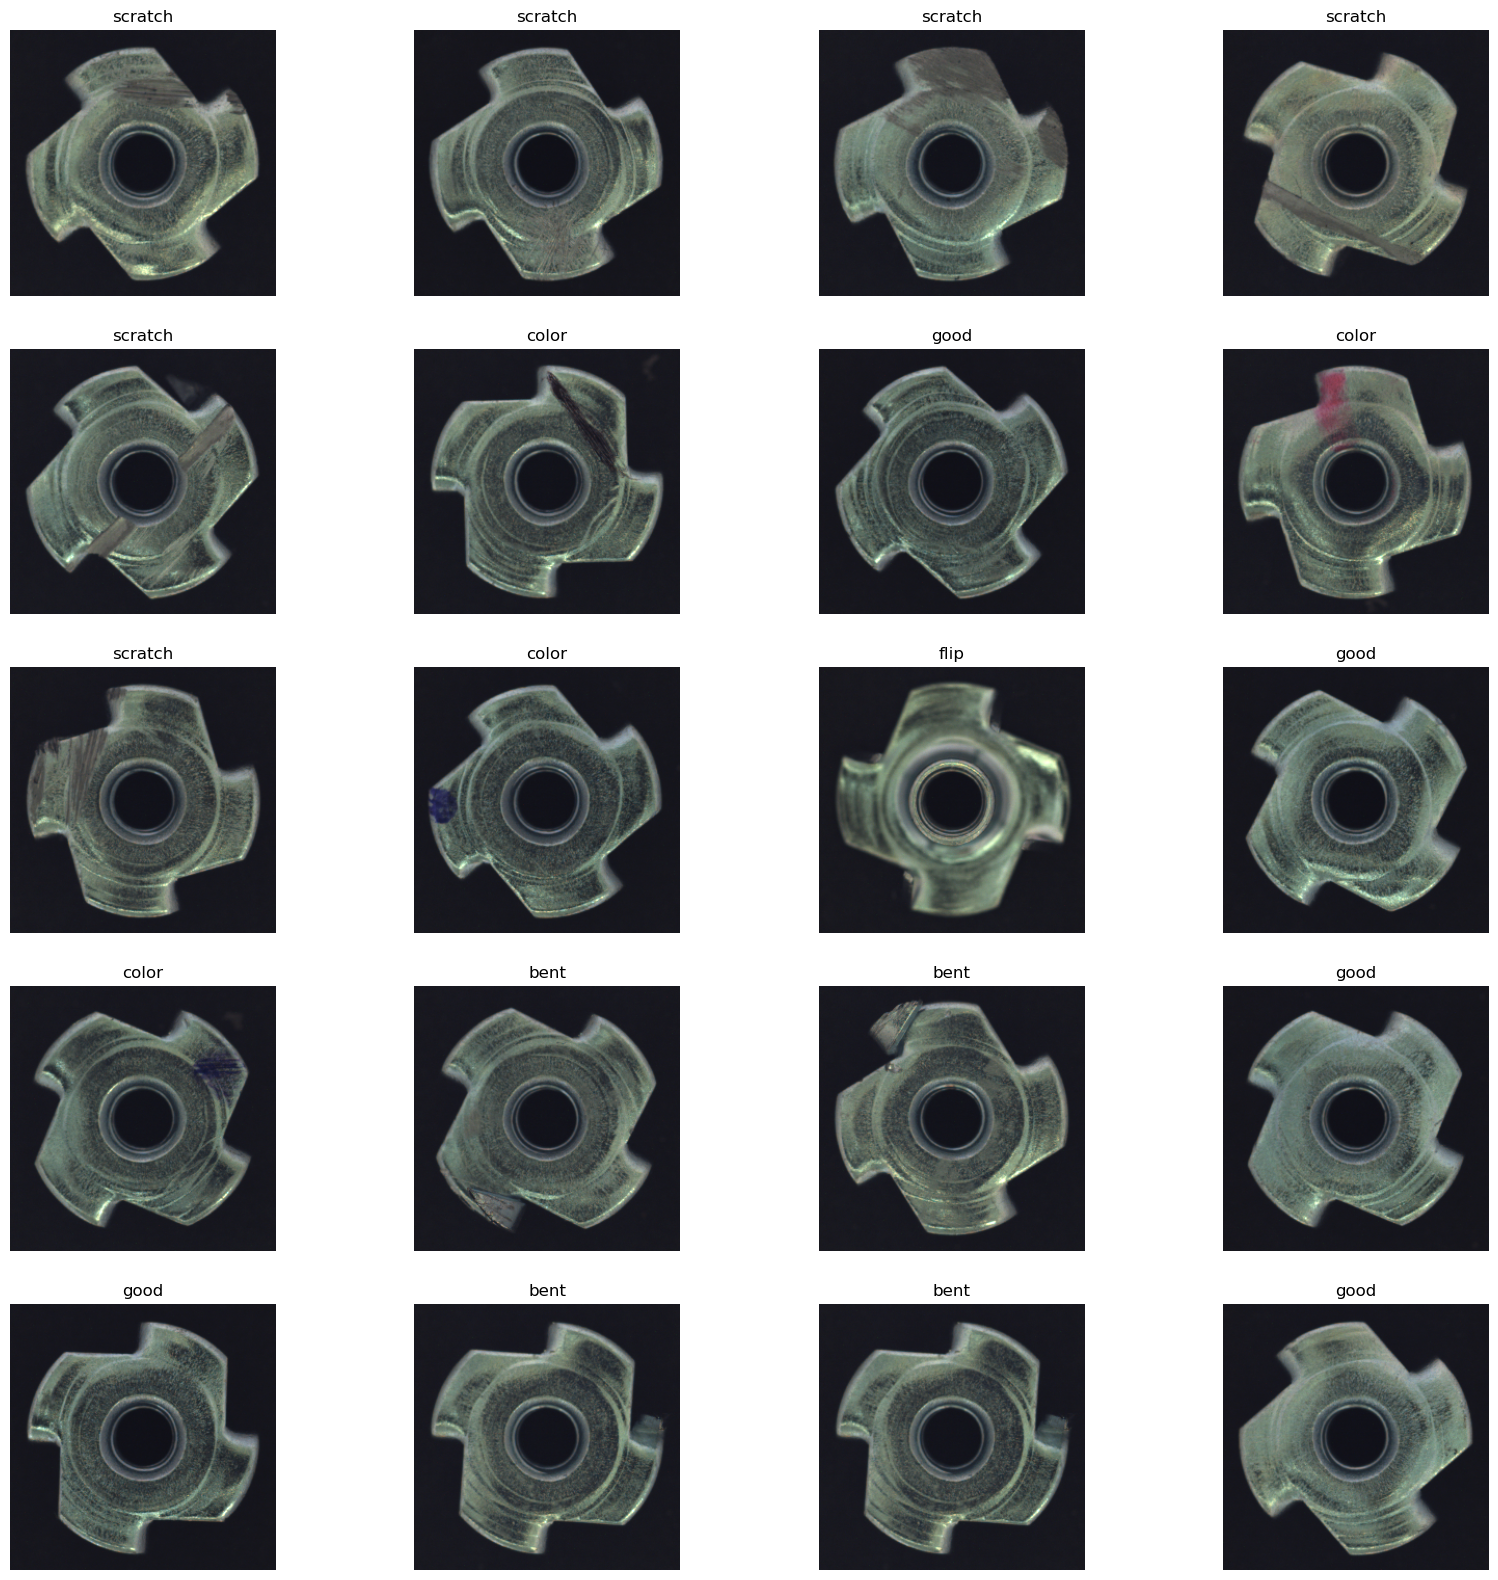

In [7]:
plt.figure(figsize=(20,20))
for image, label in df.take(1):
    for i in range(20):
        ax = plt.subplot(5,4,i+1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(class_names[label[i]])
        plt.axis("off")
#     print(image.shape)
#     print(label.numpy())

In [8]:
def get_part(df, tr_s = 0.8, te_s = 0.1, v_s = 0.1, shuffle = True, s_size = 1000):
    df_size = len(df)

    if shuffle:
        df = df.shuffle(s_size, seed = 12)

    train_size = int(tr_s * df_size)
    val_size = int(v_s * df_size)

    train_ds = df.take(train_size)

    val_ds = df.skip(train_size).take(val_size)
    test_ds = df.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds


In [9]:
train_ds, val_ds, test_ds = get_part(df)

In [10]:
len(train_ds)

12

In [11]:
len(test_ds)

2

In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [13]:
resize_rescale = tf.keras.Sequential([
    layers.Resizing(Image_Size, Image_Size),
    layers.Rescaling(1.0/255),
])


In [14]:
data_aug = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(.2)
])

In [15]:
model = models.Sequential([
    resize_rescale,
    data_aug,
    layers.Conv2D(32,(3,3),activation='relu', input_shape = input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu', input_shape= input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu', input_shape= input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu', input_shape= input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu', input_shape= input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu', input_shape= input_shape),
    layers.MaxPool2D((2,2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(5, activation = 'softmax')
])

model.build(input_shape= input_shape)

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [17]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [18]:
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)


In [19]:
history = model.fit(train_ds,
                   epochs=Epochs,
                   batch_size=Batch_Size,
                   verbose='auto',
                   validation_data=val_ds,
                   callbacks=[tensorboard_callback])

Epoch 1/85
12/12 [==============================] - 6s 352ms/step - loss: 1.5846 - accuracy: 0.2960 - val_loss: 1.5449 - val_accuracy: 0.3438
Epoch 2/85
12/12 [==============================] - 3s 238ms/step - loss: 1.5716 - accuracy: 0.3013 - val_loss: 1.5259 - val_accuracy: 0.3438
Epoch 3/85
12/12 [==============================] - 3s 218ms/step - loss: 1.5386 - accuracy: 0.3013 - val_loss: 1.3344 - val_accuracy: 0.4062
Epoch 4/85
12/12 [==============================] - 2s 207ms/step - loss: 1.3655 - accuracy: 0.3653 - val_loss: 1.2844 - val_accuracy: 0.4062
Epoch 5/85
12/12 [==============================] - 3s 222ms/step - loss: 1.4185 - accuracy: 0.4107 - val_loss: 1.3461 - val_accuracy: 0.5000
Epoch 6/85
12/12 [==============================] - 3s 217ms/step - loss: 1.4027 - accuracy: 0.3893 - val_loss: 1.0535 - val_accuracy: 0.5625
Epoch 7/85
12/12 [==============================] - 3s 216ms/step - loss: 1.3793 - accuracy: 0.4213 - val_loss: 1.0231 - val_accuracy: 0.5000
Epoch 

In [20]:
%tensorboard --logdir logs

In [21]:
scores = model.evaluate(test_ds)

2/2 [==============================] - 2s 49ms/step - loss: 0.7099 - accuracy: 0.8750


In [22]:
scores

[0.7098984718322754, 0.875]

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

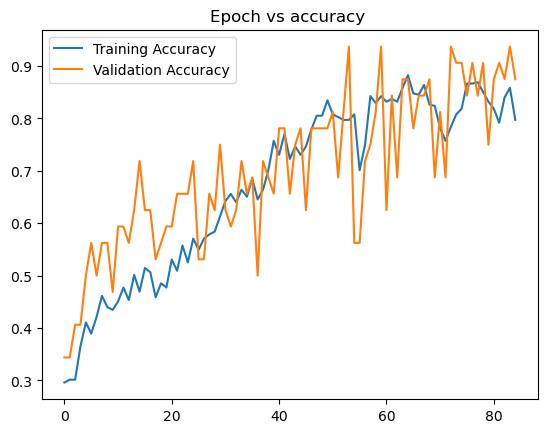

In [24]:
plt.plot(range(Epochs), acc, label = 'Training Accuracy')
plt.plot(range(Epochs), val_acc, label = 'Validation Accuracy')
plt.title("Epoch vs accuracy ")
plt.legend()

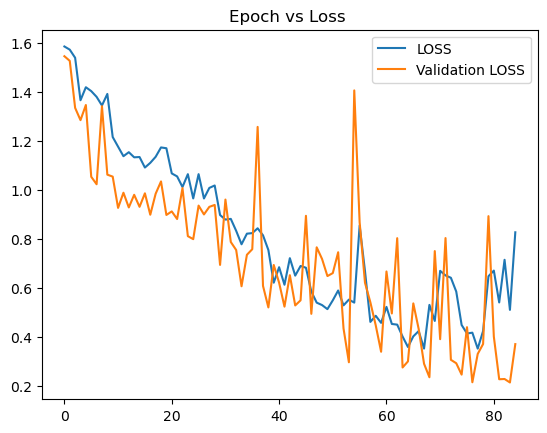

In [25]:
plt.plot(range(Epochs), loss, label = "LOSS")
plt.plot(range(Epochs), val_loss, label = "Validation LOSS")
plt.title("Epoch vs Loss ")
plt.legend()

First Image
Actual Label:  good
1/1 [==============================] - 0s 185ms/step
good


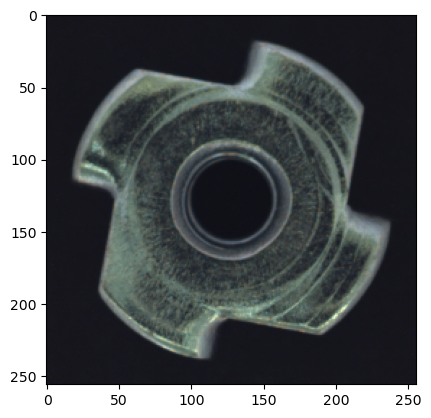

In [26]:
for images_batch, label_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()
    
    
    print("First Image")
    plt.imshow(first_image)
    print("Actual Label: ", class_names[first_label])
    
    batch_pred = model.predict(images_batch)
    print(class_names[np.argmax(batch_pred[0])])